In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

import tempfile
logdir = tempfile.mkdtemp()
print(logdir)

/tmp/tmpdf0v_zqb


In [2]:
b = tf.Variable(tf.zeros((100,)))
W = tf.Variable(tf.random_uniform((784, 100),-1,1))

x = tf.placeholder(tf.float32, (None, 784), name="x")
h_i = tf.nn.relu(tf.matmul(x, W) + b)

In [3]:
tf.reset_default_graph()

In [4]:
x_batch = np.linspace(-1,1,101)
y_batch = x_batch * 2 + np.random.randn(*x_batch.shape) * 0.3

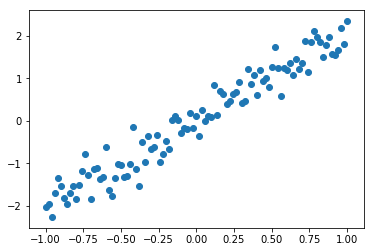

In [5]:
plt.scatter(x_batch, y_batch)

In [6]:
x = tf.placeholder(tf.float32, shape=(None,), name="x")
y = tf.placeholder(tf.float32, shape=(None,), name="y")
print(x.get_shape())

(?,)


In [7]:

w = tf.Variable(np.random.normal(), name="W")

In [8]:
y_pred = tf.multiply(w, x)

In [9]:
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [10]:
y_pred_batch = sess.run(y_pred, {x: x_batch})

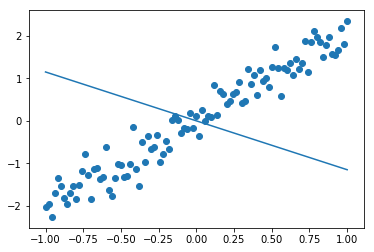

In [11]:
plt.figure(1)
plt.scatter(x_batch, y_batch)
plt.plot(x_batch, y_pred_batch)

In [12]:
cost = tf.reduce_mean(tf.square(y_pred - y))

In [13]:

summary_op = tf.summary.scalar("cost", cost)

In [14]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
train_op = optimizer.minimize(cost)

In [15]:
summary_writer = tf.summary.FileWriter(logdir, sess.graph_def)

In [16]:
for t in range(30):
    cost_t, summary, _ = sess.run([cost, summary_op, train_op], {x: x_batch, y: y_batch})
    summary_writer.add_summary(summary, t)
    print(cost_t.mean())

3.57719
3.11911
2.72121
2.37558
2.07536
1.81459
1.58807
1.39131
1.2204
1.07195
0.942994
0.830983
0.733688
0.649174
0.575764
0.511998
0.45661
0.408498
0.366707
0.330406
0.298874
0.271485
0.247694
0.227029
0.209079
0.193486
0.179943
0.168178
0.157959
0.149083


In [17]:
y_pred_batch = sess.run(y_pred, {x: x_batch})

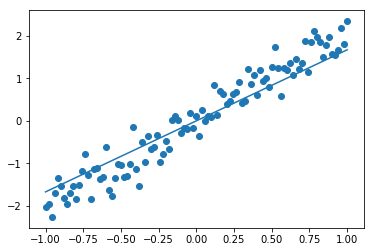

In [18]:

plt.figure(1)
plt.scatter(x_batch, y_batch)
plt.plot(x_batch, y_pred_batch)

In [19]:
summary_writer.flush()

In [20]:
import tensorflow.contrib.legacy_seq2seq as seq2seq
from tensorflow.python.ops import rnn_cell

In [21]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [22]:
seq_length = 5
batch_size = 64

vocab_size = 7
embedding_dim = 50

memory_dim = 100


In [23]:
with tf.device("/cpu:0"):
    enc_inp = [tf.placeholder(tf.int32, shape=(None,),
                              name="inp%i" % t)
               for t in range(seq_length)]

    labels = [tf.placeholder(tf.int32, shape=(None,),
                            name="labels%i" % t)
              for t in range(seq_length)]

    weights = [tf.ones_like(labels_t, dtype=tf.float32)
               for labels_t in labels]

In [24]:
# Decoder input: prepend some "GO" token and drop the final
# token of the encoder input
with tf.device("/cpu:0"):
    dec_inp = ([tf.zeros_like(enc_inp[0], dtype=np.int32, name="GO")]
               + enc_inp[:-1])

    # Initial memory value for recurrence.
    prev_mem = tf.zeros((batch_size, memory_dim))

print(tf.zeros_like(enc_inp[0], dtype=np.int32, name="GO"))

Tensor("GO_1:0", shape=(?,), dtype=int32)


In [25]:
with tf.device("/cpu:0"):
    cell = rnn_cell.GRUCell(memory_dim)

    dec_outputs, dec_memory = seq2seq.embedding_rnn_seq2seq(
        enc_inp, dec_inp, cell, vocab_size, vocab_size, embedding_dim)

In [26]:
with tf.device("/cpu:0"):

    loss = seq2seq.sequence_loss(dec_outputs, labels, weights, vocab_size)

In [27]:
with tf.device("/cpu:0"):
    tf.summary.scalar("loss", loss)

In [28]:
with tf.device("/cpu:0"):
    magnitude = tf.sqrt(tf.reduce_sum(tf.square(dec_memory[1])))
    tf.summary.scalar("magnitude at t=1", magnitude)

INFO:tensorflow:Summary name magnitude at t=1 is illegal; using magnitude_at_t_1 instead.


In [29]:
with tf.device("/cpu:0"):
    summary_op = tf.summary.merge_all()

In [30]:

learning_rate = 0.05
momentum = 0.9
with tf.device("/cpu:0"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    train_op = optimizer.minimize(loss)

In [31]:
logdir = tempfile.mkdtemp()
print(logdir)
summary_writer = tf.summary.FileWriter(logdir, sess.graph_def)

/tmp/tmpuesr675k


In [32]:
sess.run(tf.global_variables_initializer())

In [33]:

def train_batch(batch_size):
    with tf.device("/cpu:0"):
        X = [np.random.choice(vocab_size, size=(seq_length,), replace=False)
             for _ in range(batch_size)]
        Y = X[:]

        # Dimshuffle to seq_len * batch_size
        X = np.array(X).T
        Y = np.array(Y).T

        feed_dict = {enc_inp[t]: X[t] for t in range(seq_length)}
        feed_dict.update({labels[t]: Y[t] for t in range(seq_length)})

        _, loss_t, summary = sess.run([train_op, loss, summary_op], feed_dict)
    return loss_t, summary

In [34]:
for t in range(500):
    loss_t, summary = train_batch(batch_size)
    print(loss_t)
    summary_writer.add_summary(summary, t)
summary_writer.flush()

1.949
1.94226
1.93869
1.94687
1.93835
1.94604
1.93718
1.93486
1.92325
1.92037
1.91803
1.92054
1.91143
1.9085
1.90461
1.89999
1.89519
1.88353
1.88847
1.87927
1.87516
1.86941
1.87024
1.86226
1.85546
1.84727
1.84419
1.83606
1.84112
1.82668
1.83262
1.82415
1.81589
1.81202
1.80862
1.79835
1.79065
1.78537
1.78457
1.79152
1.77746
1.77582
1.75665
1.7582
1.75308
1.7518
1.73644
1.74263
1.72984
1.71196
1.71098
1.70567
1.70197
1.69071
1.69065
1.67565
1.66853
1.66601
1.65346
1.65584
1.63347
1.63014
1.63439
1.62317
1.60218
1.60188
1.60477
1.57895
1.57907
1.5561
1.54878
1.54468
1.5334
1.5296
1.51799
1.51381
1.4948
1.47947
1.4753
1.46497
1.45326
1.44443
1.42466
1.41893
1.40913
1.39791
1.37996
1.37607
1.36515
1.33488
1.3375
1.31912
1.31205
1.30549
1.27462
1.29021
1.2709
1.2405
1.23136
1.23289
1.21913
1.18957
1.17986
1.16465
1.13505
1.13072
1.13924
1.11582
1.09614
1.07128
1.07952
1.06151
1.03621
1.02722
1.01255
0.988726
0.97497
0.978328
0.962004
0.952466
0.940969
0.915715
0.892946
0.898654
0.864662
0.85